<a href="https://colab.research.google.com/github/ThomAllard/DenoisingNetworks/blob/main/TP4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet INF8225

# Before Starting
1. Go to: https://www.kaggle.com/competitions/ultrasound-nerve-segmentation/rules

2. Accept the rules

In [ ]:
#!pip install git+https://github.com/ludvb/batchrenorm@master #Pour Br-U-Net indépendemment

/content


In [ ]:
#  !pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
#  !pip install Cython

# CUDA Setup

In [ ]:
import torch
import os
os.system('export LD_LIBRARY_PATH=/usr/lib/wsl/lib:$LD_LIBRARY_PATH')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config constants

In [ ]:
NUM_WORKERS = 4

# Dataset

## Download data

In [ ]:
def download_data():
  from google.colab import drive
  drive.mount('/content/gdrive')

  # Upload the kaggle.json file

  from google.colab import files

  files.upload() #this will prompt you to upload the kaggle.json found on your Kaggle profile

  #make sure kaggle.json file is present
  !ls -lha kaggle.json

  #Install kaggle API client
  !pip install -q kaggle

  #kaggle API client expects the file to be in ~/.kaggle so move it there
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/

  #we need to set permissions
  !chmod 600 /root/.kaggle/kaggle.json

  #check your directory before downloading the datasets
  !pwd

  #list all available datasets
  !kaggle competitions list

  #download the required dataset from kaggle
  !kaggle competitions download -c ultrasound-nerve-segmentation

  #If your file is a zip file you can unzip with the following code
  !unzip ultrasound-nerve-segmentation.zip

download_data()

Mounted at /content/gdrive


Streaming output truncated to the last 5000 lines.
  inflating: train/34_115.tif        
  inflating: train/34_115_mask.tif   
  inflating: train/34_116.tif        
  inflating: train/34_116_mask.tif   
  inflating: train/34_117.tif        
  inflating: train/34_117_mask.tif   
  inflating: train/34_118.tif        
  inflating: train/34_118_mask.tif   
  inflating: train/34_119.tif        
  inflating: train/34_119_mask.tif   
  inflating: train/34_11_mask.tif    
  inflating: train/34_12.tif         
  inflating: train/34_12_mask.tif    
  inflating: train/34_13.tif         
  inflating: train/34_13_mask.tif    
  inflating: train/34_14.tif         
  inflating: train/34_14_mask.tif    
  inflating: train/34_15.tif         
  inflating: train/34_15_mask.tif    
  inflating: train/34_16.tif         
  inflating: train/34_16_mask.tif    
  inflating: train/34_17.tif         
  inflating: train/34_17_mask.tif    
  inflating: train/34_18.tif         
  inflating: train/34_18_mask.tif    

## Dataset class

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the dataset class for handling input images
class NoisyDataset(Dataset):
    def __init__(self, clean_images, speckle_mean_add=0, speckle_std_add=0.1, speckle_mean_mul=0, speckle_std_mul=1, transform=None): #Specle_std_mul = [0.1,0.5,1]
        # Noise parameters
        self.speckle_mean_add = speckle_mean_add
        self.speckle_std_add = speckle_std_add
        self.speckle_mean_mul = speckle_mean_mul
        self.speckle_std_mul = speckle_std_mul

        # Images preprocessing
        self.clean_images = self._preprocessing(clean_images)
        self.noisy_images = self._add_speckle_noise(self.clean_images)

        # Additional transforms
        self.transform = transform

    def __len__(self):
        """
        Return the number of noisy and clean images.
        """
        return len(self.clean_images)

    def __getitem__(self, idx):
        """
        Return the idx-th noisy and clean images.
        """
        clean_img = self.clean_images[idx]
        noisy_img = self.noisy_images[idx]
        if self.transform:
            clean_img = self.transform(clean_img)
            noisy_img = self.transform(noisy_img)
        return noisy_img, clean_img

    def _preprocessing(self, clean_images):
        """
        Transform the input images to tensors and normalize them.
        """
        # Reshape the images to size (128, 128)
        clean_images = [img.resize((128, 128)) for img in clean_images]

        # Define transforms
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        # Apply transforms
        clean_images = [transform(img) for img in  clean_images]

        return clean_images

    def _add_speckle_noise(self, clean_images):
        """
        Create the noisy_images dataset from the clean_images dataset.
        """

        # Create a list to store the noisy images
        noisy_images = []

        # Iterate over the clean images
        for clean_image in clean_images:
            noisy_image = self.add_speckle_noise(clean_image)
            noisy_images.append(noisy_image)

        # Normalize the noisy images
        norm = transforms.Normalize(mean=[0.5], std=[0.5])
        noisy_images = [norm(img) for img in noisy_images]

        return noisy_images


    def add_speckle_noise(self, image):
        """
        Add speckle noise to an image.

        Args:
        - image (torch.Tensor): Input image data in grayscale.

        Returns:
        - torch.Tensor: Noisy image data.
        """
        _, row, col = image.shape
        additive_gauss = torch.normal(self.speckle_mean_add, self.speckle_std_add, (row, col)).reshape(row, col)
        multiplicative_gauss = torch.normal(self.speckle_mean_mul, self.speckle_std_mul, (row, col)).reshape(row, col)
        noisy = image + image * multiplicative_gauss + additive_gauss
        return noisy

## Data loading

Displaying the first 5 images from the dataset...
Loading 5 train images...


100%|██████████| 5/5 [00:00<00:00, 296.36it/s]


Loading 5 test images...


100%|██████████| 5/5 [00:00<00:00, 313.78it/s]

Loaded 5 train and 5 test images.
The train_val images are of size torch.Size([1, 128, 128]) and have pixel values in the range [-0.9764705896377563, 1.0].
The test images are of size torch.Size([1, 128, 128]) and have pixel values in the range [-1.0, 1.0].


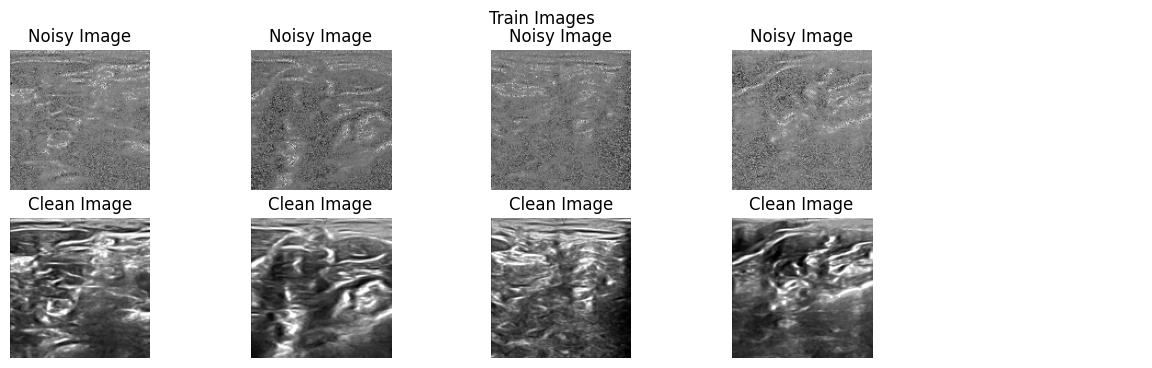

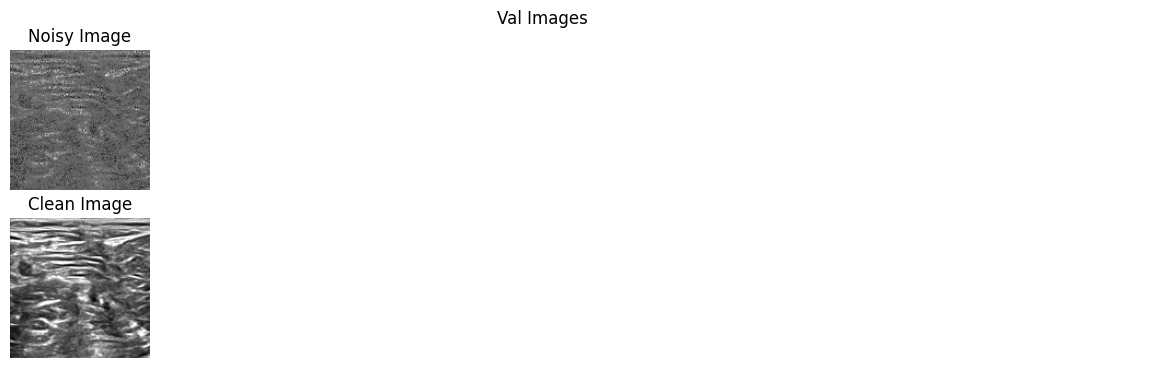

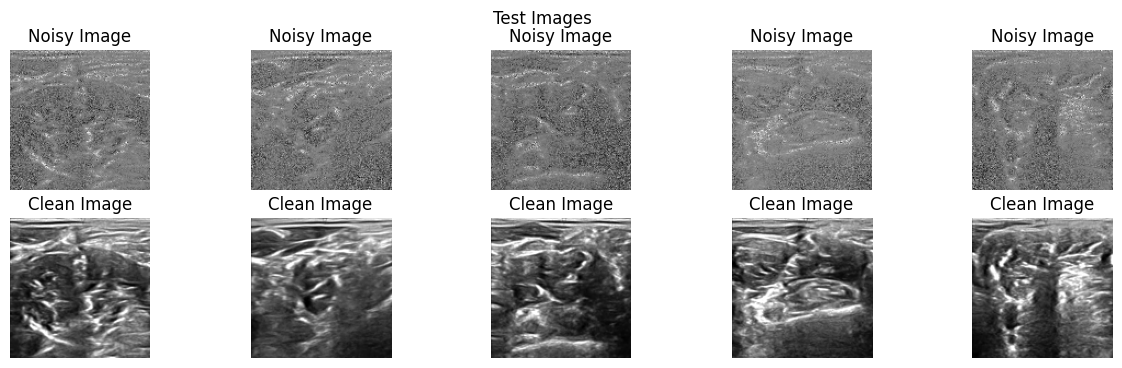

In [ ]:
from numpy import mean
import torch
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader

def train_test_split(train_images_dir = "/content/train", test_images_dir = "/content/test", train_portion=0.8, trim=None):
    """
    Method to load the train and test images from the specified directories.
    :param train_images_dir: The directory containing the train images.
    :param test_images_dir: The directory containing the test images.
    :param trim: The number of images to load. If None, all images are loaded.
    :return: The train and test datasets.
    """
    # Get the list of image filenames
    train_image_filenames = [filename for filename in os.listdir(train_images_dir) if filename.endswith(".tif") and not filename.endswith("mask.tif")]
    test_image_filenames = [filename for filename in os.listdir(test_images_dir) if filename.endswith(".tif") and not filename.endswith("mask.tif")]

    # Trimming to avoid a bug in test data plotting I'm too lazy to fix
    # TODO: Properly resolve the plotting bug when no trim is applied
    if trim is None:
        trim = 5500

    if trim:
        train_image_filenames = train_image_filenames[:trim]  # Use the first 10 images for demonstration
        test_image_filenames = test_image_filenames[:trim]  # Use the first 10 images for demonstration

    print(f'Loading {len(train_image_filenames)} train images...')

    # Load the train images
    train_images = []
    for filename in tqdm(train_image_filenames):
        image = Image.open(os.path.join(train_images_dir, filename)).convert('L')
        train_images.append(image)

    print(f'Loading {len(test_image_filenames)} test images...')

    # Load the test images
    test_images = []
    for filename in tqdm(test_image_filenames):
        image = Image.open(os.path.join(test_images_dir, filename)).convert('L')
        test_images.append(image)

    print(f'Loaded {len(train_images)} train and {len(test_images)} test images.')

    # Create two NoisyDataset with the loaded images
    train_val_dataset = NoisyDataset(train_images)
    test_dataset = NoisyDataset(test_images)

    # Print the average pixel range for the whole dataset
    print(f'The train_val images are of size {train_val_dataset.clean_images[0].shape} and have pixel values in the range [{mean([train_val_dataset.clean_images[i].min() for i in range(len(train_val_dataset.clean_images))])}, {mean([train_val_dataset.clean_images[i].max() for i in range(len(train_val_dataset.clean_images))])}].')
    print(f'The test images are of size {test_dataset.clean_images[0].shape} and have pixel values in the range [{mean([test_dataset.clean_images[i].min() for i in range(len(test_dataset.clean_images))])}, {mean([test_dataset.clean_images[i].max() for i in range(len(test_dataset.clean_images))])}].')

    # Split dataset into train and validation
    train_size = int(train_portion * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

    return train_dataset, val_dataset, test_dataset

def get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):
    """
    Method to create the train, validation and test data loaders.
    :param train_dataset: The training dataset.
    :param val_dataset: The validation dataset.
    :param test_dataset: The test dataset.
    :param batch_size: The batch size.
    :return: The train, validation and test data loaders.
    """
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=NUM_WORKERS)
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=NUM_WORKERS)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=NUM_WORKERS)

    return train_dataloader, val_dataloader, test_dataloader

def peek_dataset(num_images=5):
    """
    Display the first num_images images from the dataset.
    :param num_images: The number of images to display.
    """

    print(f'Displaying the first {num_images} images from the dataset...')

    train_dataset, val_dataset, test_dataset = train_test_split(trim=num_images)

    # Display the first 10 train clean and noisy images
    figsize=(15, 14 - 2*num_images if num_images<=5 else 4)

    fig, axs = plt.subplots(2, num_images, figsize=figsize)
    fig.suptitle('Train Images')
    for i in range(num_images):
        if i<len(train_dataset):
            noisy_img, clean_img = train_dataset[i]
            axs[0, i].imshow(noisy_img[0], cmap='gray')
            axs[0, i].set_title('Noisy Image')
            axs[1, i].imshow(clean_img[0], cmap='gray')
            axs[1, i].set_title('Clean Image')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.show()

    # Display the first 10 val clean and noisy images
    fig, axs = plt.subplots(2, num_images, figsize=figsize)
    fig.suptitle('Val Images')
    for i in range(num_images):
        if i<len(val_dataset):
            noisy_img, clean_img = val_dataset[i]
            axs[0, i].imshow(noisy_img[0], cmap='gray')
            axs[0, i].set_title('Noisy Image')
            axs[1, i].imshow(clean_img[0], cmap='gray')
            axs[1, i].set_title('Clean Image')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.show()

    # Display the first 10 test clean and noisy images
    fig, axs = plt.subplots(2, num_images, figsize=figsize)
    fig.suptitle('Test Images')
    for i in range(num_images):
        if i<len(test_dataset):
            noisy_img, clean_img = test_dataset[i]
            axs[0, i].imshow(noisy_img[0], cmap='gray')
            axs[0, i].set_title('Noisy Image')
            axs[1, i].imshow(clean_img[0], cmap='gray')
            axs[1, i].set_title('Clean Image')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.show()

peek_dataset(5)

# Define nets

## Di-Conv-AE-Net

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the Dilated Convolutional Autoencoder
class DilatedConvAutoencoder(nn.Module):
    def __init__(self):
        super(DilatedConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, padding=2, dilation=2),
            nn.LeakyReLU(0.1),

            nn.MaxPool2d(2, 2),

            nn.Dropout(0.2),

            nn.BatchNorm2d(256),

            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.LeakyReLU(0.1),

            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.LeakyReLU(0.1),

            nn.Dropout(0.2),
        )

        # Decoder that mirrors the encoder's dilation pattern
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=2, dilation=2),
            nn.LeakyReLU(0.1),

            # Upsampling
            # nn.Upsample(scale_factor=2, mode='nearest'),  # Upsampling to 128x128
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # Replaces nn.Upsample

            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=2, dilation=2),
            nn.LeakyReLU(0.1),

            nn.Dropout(0.2),

            nn.Conv2d(128, 128, kernel_size=3, padding=2, dilation=2),
            nn.LeakyReLU(0.1),

            nn.Conv2d(128, 1, kernel_size=3, padding=2, dilation=2),
            nn.Tanh()  # Normalize output pixels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## D-U-Net

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.dropout = nn.Dropout(0.1)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(0.1)

    def forward(self, x):
        x = self.dropout(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        return x

class DenoisingUNet(nn.Module):
    def __init__(self):
        super(DenoisingUNet, self).__init__()

        self.block1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(0.1)
                                    )
        self.block2 = nn.Sequential(nn.MaxPool2d(2, 2),
                                    Block(32, 64)
                                    )
        self.block3 = nn.Sequential(nn.MaxPool2d(2, 2),
                                    Block(64, 128)
                                    )
        self.block4 = nn.Sequential(nn.MaxPool2d(2, 2),
                                    Block(128, 256)
                                    )
        self.bottom = nn.Sequential(nn.MaxPool2d(2, 2),
                                     Block(256, 512),
                                     nn.ConvTranspose2d(512, 512, 2, output_padding=0)
                                     )

        # Decoder
        self.dec_block_1 = Block(768, 256)
        self.dec_block_2 = nn.Sequential(Block(384, 128),
                                          nn.BatchNorm2d(128))
        self.dec_block_3 = nn.Sequential(Block(192, 64),
                                          nn.BatchNorm2d(64))
        self.dec_block_4 = nn.Sequential(Block(96, 32),
                                          nn.BatchNorm2d(32))
        self.last_conv = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)
        x5 = self.bottom(x4)
        x5_interpol = F.interpolate(x5, size=x4.shape[2:], mode='bilinear', align_corners=False)
        cat_1 = torch.cat([x5_interpol, x4], dim=1)
        x6 = self.dec_block_1(cat_1)
        x6_interpol = F.interpolate(x6, size=x3.shape[2:], mode='bilinear', align_corners=False)
        cat_2 = torch.cat([x6_interpol, x3], dim=1)
        x7 = self.dec_block_2(cat_2)
        x7_interpol = F.interpolate(x7, size=x2.shape[2:], mode='bilinear', align_corners=False)
        cat_3 = torch.cat([x7_interpol, x2], dim=1)
        x8 = self.dec_block_3(cat_3)
        x8_interpol = F.interpolate(x8, size=x1.shape[2:], mode='bilinear', align_corners=False)
        cat_4 = torch.cat([x8_interpol, x1], dim=1)
        x9 = self.dec_block_4(cat_4)
        x10 = self.last_conv(x9)
        return x10


## Br-U-Net

In [ ]:
#BatchRenorm2d issu du Git: https://github.com/ludvb/batchrenorm/tree/master
#Implémentation donne des images noires
import torch


__all__ = ["BatchRenorm1d", "BatchRenorm2d", "BatchRenorm3d"]


class BatchRenorm(torch.jit.ScriptModule):
    def __init__(
        self,
        num_features: int,
        eps: float = 1e-3,
        momentum: float = 0.01,
        affine: bool = True,
    ):
        super().__init__()
        self.register_buffer(
            "running_mean", torch.zeros(num_features, dtype=torch.float)
        )
        self.register_buffer(
            "running_std", torch.ones(num_features, dtype=torch.float)
        )
        self.register_buffer(
            "num_batches_tracked", torch.tensor(0, dtype=torch.long)
        )
        self.weight = torch.nn.Parameter(
            torch.ones(num_features, dtype=torch.float)
        )
        self.bias = torch.nn.Parameter(
            torch.zeros(num_features, dtype=torch.float)
        )
        self.affine = affine
        self.eps = eps
        self.step = 0
        self.momentum = momentum

    def _check_input_dim(self, x: torch.Tensor) -> None:
        raise NotImplementedError()  # pragma: no cover

    @property
    def rmax(self) -> torch.Tensor:
        return (2 / 35000 * self.num_batches_tracked + 25 / 35).clamp_(
            1.0, 3.0
        )

    @property
    def dmax(self) -> torch.Tensor:
        return (5 / 20000 * self.num_batches_tracked - 25 / 20).clamp_(
            0.0, 5.0
        )

    def forward(self, x: torch.Tensor, mask = None) -> torch.Tensor:
        '''
        Mask is a boolean tensor used for indexing, where True values are padded
        i.e for 3D input, mask should be of shape (batch_size, seq_len)
        mask is used to prevent padded values from affecting the batch statistics
        '''
        self._check_input_dim(x)
        if x.dim() > 2:
            x = x.transpose(1, -1)
        if self.training:
            dims = [i for i in range(x.dim() - 1)]
            if mask is not None:
                z = x[~mask]
                batch_mean = z.mean(0)
                batch_std = z.std(0, unbiased=False) + self.eps
            else:
                batch_mean = x.mean(dims)
                batch_std = x.std(dims, unbiased=False) + self.eps

            r = (
                batch_std.detach() / self.running_std.view_as(batch_std)
            ).clamp_(1 / self.rmax, self.rmax)
            d = (
                (batch_mean.detach() - self.running_mean.view_as(batch_mean))
                / self.running_std.view_as(batch_std)
            ).clamp_(-self.dmax, self.dmax)
            x = (x - batch_mean) / batch_std * r + d
            self.running_mean += self.momentum * (
                batch_mean.detach() - self.running_mean
            )
            self.running_std += self.momentum * (
                batch_std.detach() - self.running_std
            )
            self.num_batches_tracked += 1
        else:
            x = (x - self.running_mean) / self.running_std
        if self.affine:
            x = self.weight * x + self.bias
        if x.dim() > 2:
            x = x.transpose(1, -1)
        return x


class BatchRenorm1d(BatchRenorm):
    def _check_input_dim(self, x: torch.Tensor) -> None:
        if x.dim() not in [2, 3]:
            raise ValueError("expected 2D or 3D input (got {x.dim()}D input)")


class BatchRenorm2d(BatchRenorm):
    def _check_input_dim(self, x: torch.Tensor) -> None:
        if x.dim() != 4:
            raise ValueError("expected 4D input (got {x.dim()}D input)")


class BatchRenorm3d(BatchRenorm):
    def _check_input_dim(self, x: torch.Tensor) -> None:
        if x.dim() != 5:
            raise ValueError("expected 5D input (got {x.dim()}D input)")

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

class Block1(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(Block1, self).__init__()
        self.conv_transpose = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation =2, stride = stride)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.05)
        self.batch_renorm = BatchRenorm2d(out_channels)

    def forward(self, x):
        x = self.conv_transpose(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.batch_renorm(x)
        return x
class Block2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Block2, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=2,dilation=2, output_padding=0)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        self.dropout = nn.Dropout(0.05)
        self.batch_renorm = BatchRenorm2d(out_channels)

    def forward(self, x):
        x = self.conv_transpose(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.batch_renorm(x)
        return x


class BatchRenormalizationUNet(nn.Module):
    def __init__(self):
        super(BatchRenormalizationUNet, self).__init__()

        # Encoder
        self.block1 = Block1(1, 64)
        self.block2 = Block1(64, 64, stride = 2)
        self.block3 = Block1(64,128, stride = 2)

        #Bottom from U
        self.bottom_block = nn.Sequential(Block1(128, 256), Block1(256, 256, stride = 2))

        #Decoder
        self.dec_block_1 = nn.Sequential(Block2(384, 384), Block1(384, 128))
        self.dec_block_2 = nn.Sequential(Block2(192, 192), Block1(192, 64))

        self.dec_block_3 = nn.Sequential(Block2(128, 128), Block1(128, 32))
        self.final = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.bottom_block(x3)
        x4_interpol = F.interpolate(x4, size=x3.shape[2:], mode='bilinear', align_corners = False)

        cat_1 = torch.cat([x4_interpol, x3], dim=1)
        x5 = self.dec_block_1(cat_1)

        x5_interpol = F.interpolate(x5, size=x2.shape[2:], mode='bilinear', align_corners = False)

        cat_2 = torch.cat([x5_interpol, x2], dim=1)
        x6 = self.dec_block_2(cat_2)

        x6_interpol = F.interpolate(x6, size=x1.shape[2:], mode='bilinear', align_corners = False)

        cat_3 = torch.cat([x6_interpol, x1], dim=1)
        x7 = self.dec_block_3(cat_3)
        x8 = self.final(x7)
        return x8


# Utils

## Results display

In [ ]:
def display_results(input_dataset, output_list, num_images=5, name='Train', epoch=-1):
    """
    Method to display the first num_images images from the dataset.
    :param output_list: The list of outputs from the model.
    :param num_images: The number of images to display.
    :param name: The name of the dataset.
    """

    if not isinstance(output_list, list):  # If the output_list is a single batch, convert it to a list
        output_list = [output_list]

    # Display the first 5 train clean, noisy, and denoised images
    fig, axs = plt.subplots(3, num_images, figsize=(15, 6))
    fig.suptitle(f'{name} Images')
    for i in range(min(len(input_dataset), num_images)):
        noisy_img, clean_img, denoised_img = output_list[epoch]
        noisy_img = noisy_img[i].squeeze()
        clean_img = clean_img[i].squeeze()
        denoised_img = denoised_img[i].squeeze()
        axs[0, i].imshow(noisy_img, cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title('Noisy Image')
        axs[1, i].imshow(clean_img, cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title('Clean Image')
        axs[2, i].imshow(denoised_img.detach().cpu(), cmap='gray')
        axs[2, i].axis('off')
        axs[2, i].set_title('Denoised Image')
    plt.show()

def display_loss(train_loss_list, val_loss_list):
    # Print the loss curve
    plt.figure()
    plt.plot(train_loss_list, label='Train')
    plt.plot(val_loss_list, label='Validation')
    plt.title('Loss Curve')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

## Test method

In [ ]:
def test(model, dataloader, loss_func) -> tuple:
    """
    Method to test the model on a given dataloader.
    :param model: The model to test.
    :param dataloader: The DataLoader object containing the test data.
    :param loss_func: The loss function to use.
    :return: The outputs and the average loss.
    """
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for noisy_imgs, clean_imgs in dataloader:
            outputs = model(noisy_imgs.to(DEVICE))
            loss = loss_func(outputs.to(DEVICE), clean_imgs.to(DEVICE))
            total_loss += loss.item()
    return (noisy_imgs, clean_imgs, outputs), loss / len(dataloader)

## Train method

In [ ]:
import time
from datetime import timedelta

# Set up the training loop
def train(model, train_dataloader, val_dataloader, epochs, loss_func, optimizer):
    """
    Method to train the model on the given dataset.
    :param model: The model to train.
    :param train_val_dataset: The dataset to train on.
    :param epochs: The number of epochs to train for.
    :param loss_func: The loss function to use.
    :param optimizer: The optimizer to use.
    :param batch_size: The batch size to use.
    :return: The lists of train outputs, train losses, validation outputs, and validation losses.
    """

    model.to(DEVICE)

    # Print the model architecture
    print(model)

    # Print the number of parameters and the the memory footprint of the model
    num_params = sum(p.numel() for p in model.parameters())
    memory_footprint = sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2
    print(f"Number of parameters: {num_params:,}\n"
          f"Model memory usage: {memory_footprint:.3f}MB\n"
          f"Using: {DEVICE}")

    # Train the model
    train_output_list = []
    train_loss_list = []
    val_output_list = []
    val_loss_list = []
    model.train()
    for epoch in tqdm(range(epochs)):
        # Train the model on the training data
        total_train_loss = 0
        first_batch = True
        for noisy_imgs, clean_imgs in train_dataloader:
            if first_batch:
                start = time.time()
            optimizer.zero_grad()
            outputs = model(noisy_imgs.to(DEVICE))
            loss = loss_func(outputs.to(DEVICE), clean_imgs.to(DEVICE))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            end = time.time()
            if first_batch:
                print(f"Estimated time for epoch: {timedelta(seconds=end - start)*len(train_dataloader)}.")
                first_batch = False

        # Store the train outputs and losses
        train_output_list.append((noisy_imgs, clean_imgs, outputs))
        train_loss_list.append(total_train_loss/len(train_dataloader))

        # Infer the model on the validation data
        val_outputs, val_loss = test(model, val_dataloader, loss_func)

        # Store the validation outputs and losses
        val_output_list.append(val_outputs)
        val_loss_list.append(val_loss.item())
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

        # Early stop if val_loss has increased for 2 consecutive epochs
        if epoch > 1 and val_loss_list[-1] > val_loss_list[-2] and val_loss_list[-2] > val_loss_list[-3]:
            print(f"Early stopping at epoch {epoch}.")
            break

    return train_output_list, train_loss_list, val_output_list, val_loss_list

def train_test(model, train_dataset, val_dataset, test_dataset, epochs, loss_func, optimizer, batch_size = 10):
    train_dataloader, val_dataloader, test_dataloader = get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=batch_size)

    train_output_list, train_loss_list, val_output_list, val_loss_list = train(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        epochs=epochs,
        loss_func=loss_func,
        optimizer=optimizer
    )

    test_outputs, test_loss = test(model, test_dataloader, loss_func)

    display_loss(train_loss_list, val_loss_list)
    print(f'Final Test Loss: {test_loss.item()}')

    last_epoch_to_show = 1
    for i in range(max(0, epochs-last_epoch_to_show), epochs):  # Display the last 3 epochs outputs
        display_results(train_dataset, train_output_list, num_images=5, name=f'Train, epoch {i}')
        display_results(val_dataset, val_output_list, num_images=5, name=f'Validation, epoch {i}')
    display_results(test_dataset, test_outputs, num_images=5, name='Test')

    return train_output_list, train_loss_list, val_output_list, val_loss_list, test_outputs, test_loss

## Di-Conv-AE-Net

Loading 5500 train images...


100%|██████████| 5500/5500 [00:17<00:00, 317.86it/s]


Loading 5500 test images...


100%|██████████| 5500/5500 [00:17<00:00, 314.39it/s]


Loaded 5500 train and 5500 test images.
The train_val images are of size torch.Size([1, 128, 128]) and have pixel values in the range [-0.9880983829498291, 0.9999943375587463].
The test images are of size torch.Size([1, 128, 128]) and have pixel values in the range [-0.9890053272247314, 1.0].
DilatedConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (6): LeakyReLU(negative_slope=0.1)
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (8): LeakyReLU(negative_slope=0.1)
    (9): Dropout(p=0.2, inplace=False)
  )
  (de

  0%|          | 0/10 [00:00<?, ?it/s]

Estimated time for epoch: 0:01:05.260338.


 10%|█         | 1/10 [01:05<09:47, 65.32s/it]

Epoch 0, Train Loss: 0.0327 - Val Loss: 0.0008
Estimated time for epoch: 0:00:55.209936.


 20%|██        | 2/10 [02:08<08:33, 64.19s/it]

Epoch 1, Train Loss: 0.0187 - Val Loss: 0.0006
Estimated time for epoch: 0:00:55.468134.


 30%|███       | 3/10 [03:12<07:26, 63.81s/it]

Epoch 2, Train Loss: 0.0186 - Val Loss: 0.0006
Estimated time for epoch: 0:00:56.204778.


 40%|████      | 4/10 [04:15<06:21, 63.65s/it]

Epoch 3, Train Loss: 0.0182 - Val Loss: 0.0006
Estimated time for epoch: 0:00:55.763040.


 50%|█████     | 5/10 [05:18<05:17, 63.60s/it]

Epoch 4, Train Loss: 0.0196 - Val Loss: 0.0005
Estimated time for epoch: 0:00:55.923120.


 60%|██████    | 6/10 [06:22<04:13, 63.48s/it]

Epoch 5, Train Loss: 0.0159 - Val Loss: 0.0005
Estimated time for epoch: 0:00:55.802370.


 70%|███████   | 7/10 [07:25<03:10, 63.44s/it]

Epoch 6, Train Loss: 0.0177 - Val Loss: 0.0005
Estimated time for epoch: 0:00:55.959552.


 80%|████████  | 8/10 [08:28<02:06, 63.42s/it]

Epoch 7, Train Loss: 0.0178 - Val Loss: 0.0005
Estimated time for epoch: 0:00:55.654434.


 90%|█████████ | 9/10 [09:32<01:03, 63.37s/it]

Epoch 8, Train Loss: 0.0155 - Val Loss: 0.0005
Estimated time for epoch: 0:00:55.723020.


100%|██████████| 10/10 [10:35<00:00, 63.56s/it]

Epoch 9, Train Loss: 0.0164 - Val Loss: 0.0005


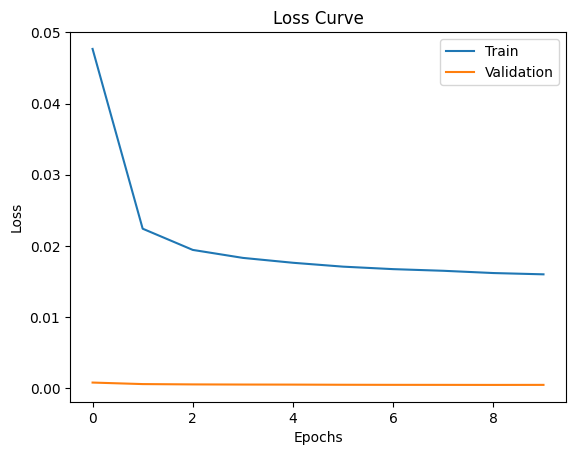

Final Test Loss: 9.570113616064191e-05


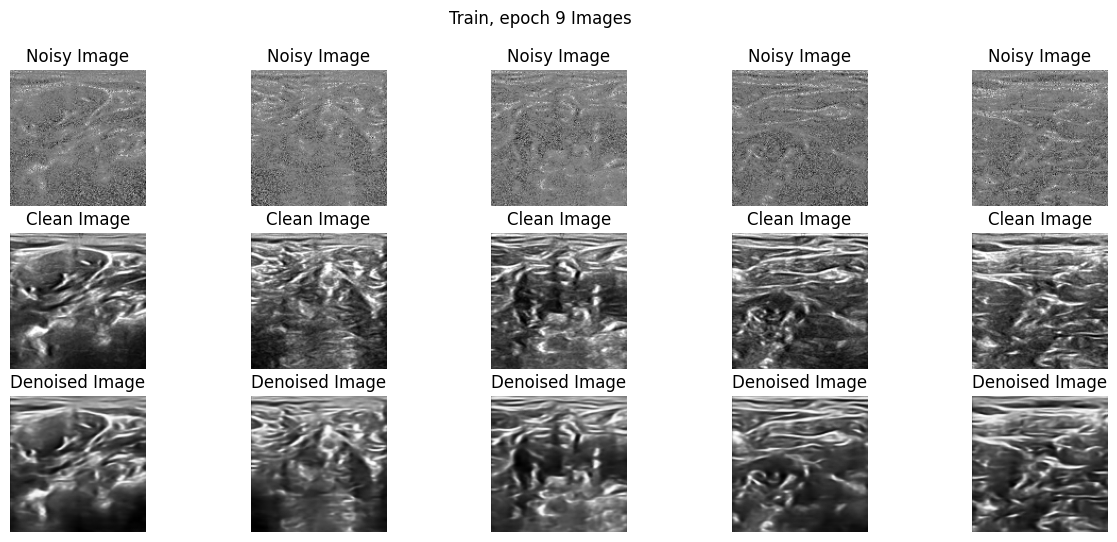

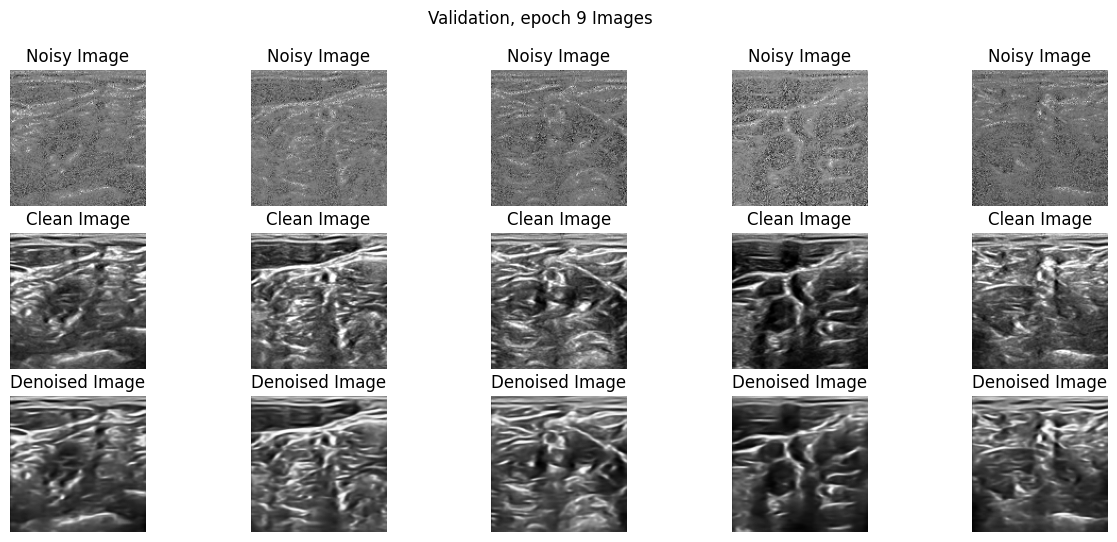

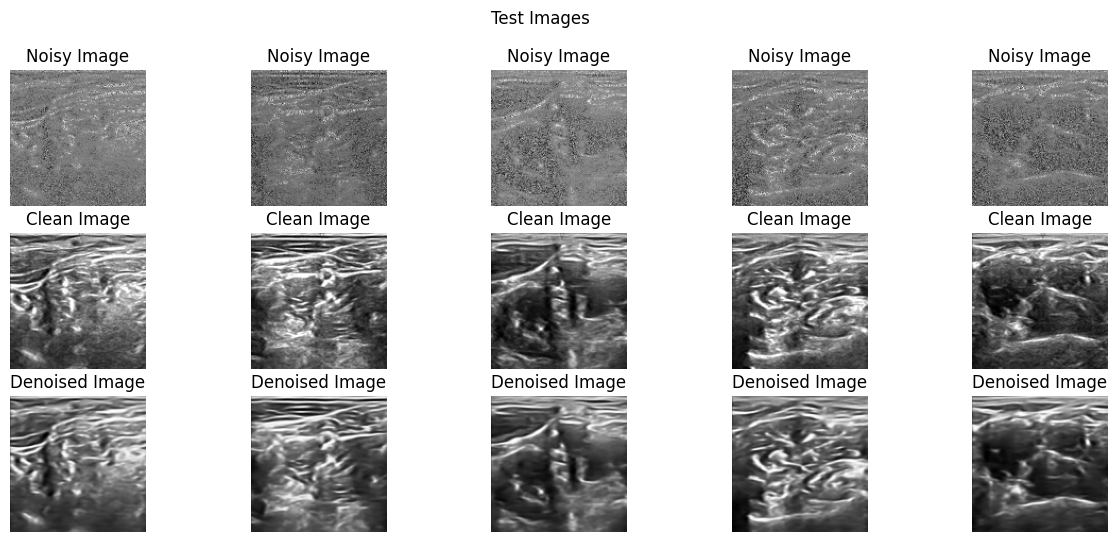

In [ ]:
# Train and test the network architecture
def launch_Di_Conv_AE():
    model = DilatedConvAutoencoder()

    train_dataset, val_dataset, test_dataset = train_test_split()  #trim=200

    train_output_list, train_loss_list, val_output_list, val_loss_list, test_output_list, test_loss_list = train_test(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        batch_size=32,
        epochs=10,
        loss_func=nn.MSELoss(),
        optimizer=optim.Adam(model.parameters(), lr=0.001)
        )

    return model

di_conv_ae = launch_Di_Conv_AE()

## D-U-Net

Loading 5500 train images...


100%|██████████| 5500/5500 [00:17<00:00, 315.36it/s]


Loading 5500 test images...


100%|██████████| 5500/5500 [00:17<00:00, 320.61it/s]


Loaded 5500 train and 5500 test images.
The train_val images are of size torch.Size([1, 128, 128]) and have pixel values in the range [-0.9880983829498291, 0.9999943375587463].
The test images are of size torch.Size([1, 128, 128]) and have pixel values in the range [-0.9890053272247314, 1.0].
DenoisingUNet(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Block(
      (dropout): Dropout(p=0.1, inplace=False)
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (block3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0,

  0%|          | 0/10 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Estimated time for epoch: 0:00:26.922420.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 10%|█         | 1/10 [00:23<03:33, 23.74s/it]

Epoch 0, Train Loss: 0.0272 - Val Loss: 0.0007
Estimated time for epoch: 0:00:18.379944.


 20%|██        | 2/10 [00:45<03:00, 22.53s/it]

Epoch 1, Train Loss: 0.0204 - Val Loss: 0.0006
Estimated time for epoch: 0:00:18.299904.


 30%|███       | 3/10 [01:06<02:34, 22.03s/it]

Epoch 2, Train Loss: 0.0199 - Val Loss: 0.0006
Estimated time for epoch: 0:00:18.158040.


 40%|████      | 4/10 [01:28<02:11, 21.90s/it]

Epoch 3, Train Loss: 0.0183 - Val Loss: 0.0005
Estimated time for epoch: 0:00:18.259884.


 50%|█████     | 5/10 [01:50<01:49, 21.84s/it]

Epoch 4, Train Loss: 0.0182 - Val Loss: 0.0005
Estimated time for epoch: 0:00:18.325572.


 60%|██████    | 6/10 [02:12<01:27, 21.81s/it]

Epoch 5, Train Loss: 0.0174 - Val Loss: 0.0005
Estimated time for epoch: 0:00:18.658842.


 70%|███████   | 7/10 [02:33<01:05, 21.77s/it]

Epoch 6, Train Loss: 0.0171 - Val Loss: 0.0005
Estimated time for epoch: 0:00:18.187296.


 80%|████████  | 8/10 [02:55<00:43, 21.76s/it]

Epoch 7, Train Loss: 0.0168 - Val Loss: 0.0005
Estimated time for epoch: 0:00:18.310530.


 90%|█████████ | 9/10 [03:17<00:21, 21.77s/it]

Epoch 8, Train Loss: 0.0168 - Val Loss: 0.0005
Estimated time for epoch: 0:00:18.213240.


100%|██████████| 10/10 [03:38<00:00, 21.88s/it]

Epoch 9, Train Loss: 0.0157 - Val Loss: 0.0004


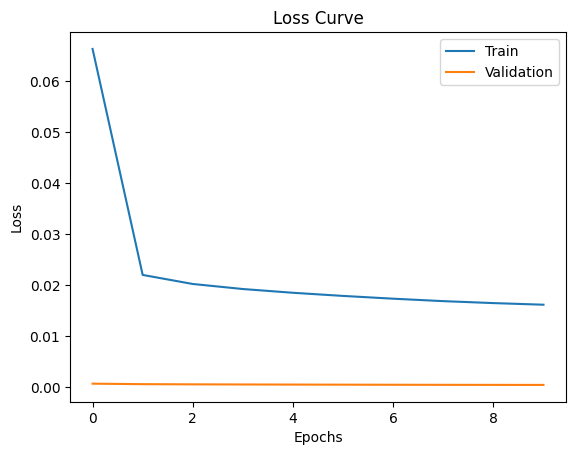

Final Test Loss: 9.372006024932489e-05


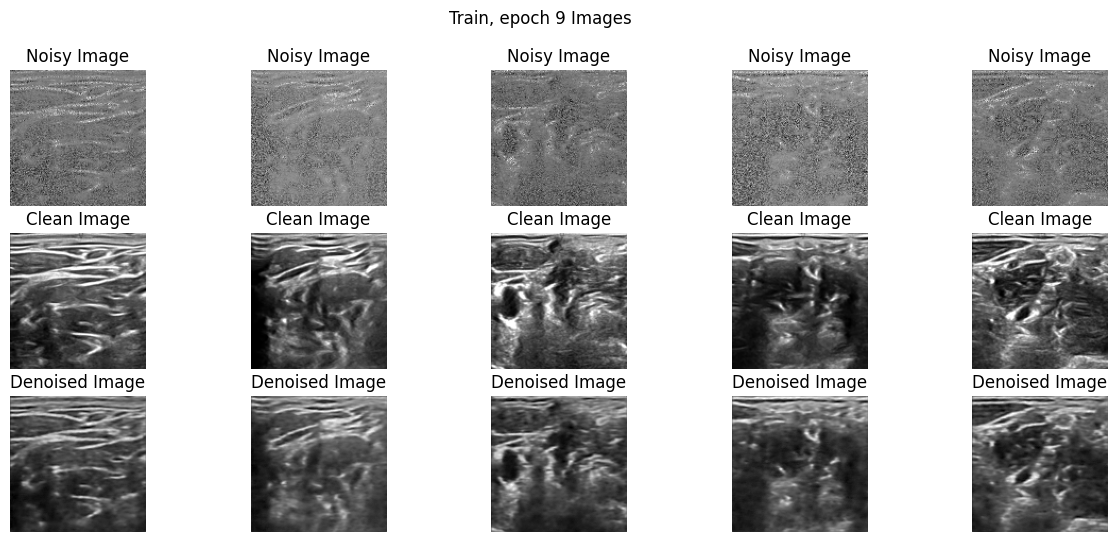

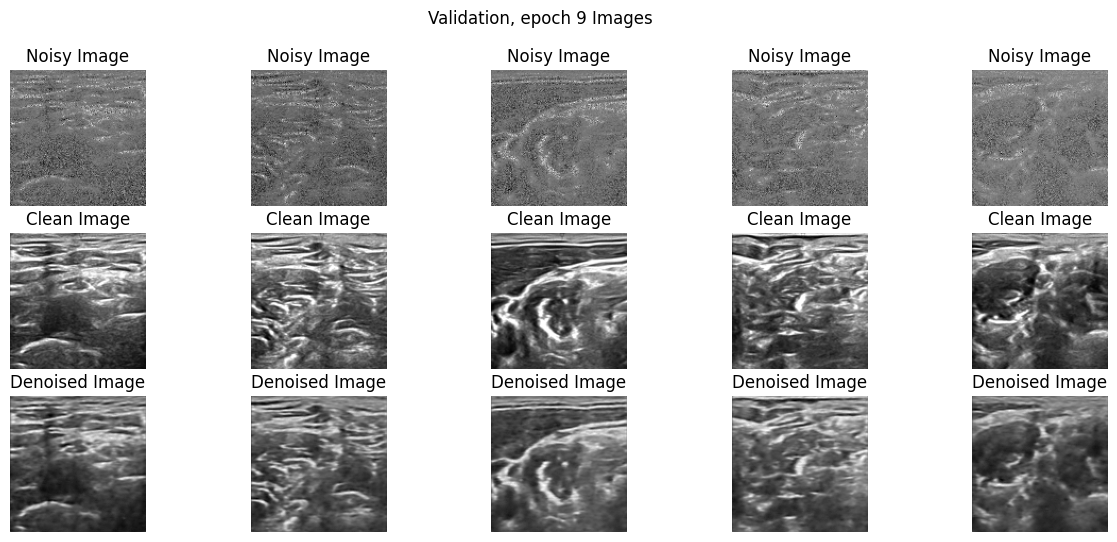

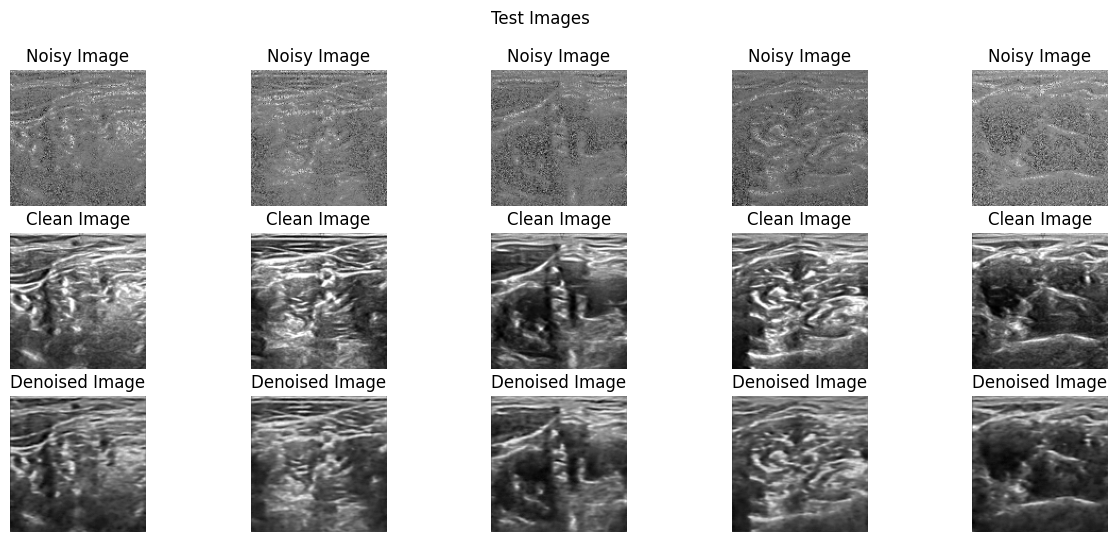

In [ ]:
# Train and test the network architecture
def launch_D_U_Net():
    model = DenoisingUNet()

    train_dataset, val_dataset, test_dataset = train_test_split()

    train_output_list, train_loss_list, val_output_list, val_loss_list, test_output_list, test_loss_list = train_test(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        batch_size=32,
        epochs=10,
        loss_func=nn.MSELoss(),
        optimizer=optim.Adamax(model.parameters(), lr=0.005)
        )

    return model

d_u_net = launch_D_U_Net()

## Br-U-Net

Loading 5500 train images...


100%|██████████| 5500/5500 [00:17<00:00, 322.27it/s]


Loading 5500 test images...


100%|██████████| 5500/5500 [00:16<00:00, 324.42it/s]


Loaded 5500 train and 5500 test images.
The train_val images are of size torch.Size([1, 128, 128]) and have pixel values in the range [-0.9880983829498291, 0.9999943375587463].
The test images are of size torch.Size([1, 128, 128]) and have pixel values in the range [-0.9890053272247314, 1.0].
BatchRenormalizationUNet(
  (block1): Block1(
    (conv_transpose): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (leaky_relu): LeakyReLU(negative_slope=0.1)
    (dropout): Dropout(p=0.05, inplace=False)
    (batch_renorm): BatchRenorm2d()
  )
  (block2): Block1(
    (conv_transpose): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2))
    (leaky_relu): LeakyReLU(negative_slope=0.1)
    (dropout): Dropout(p=0.05, inplace=False)
    (batch_renorm): BatchRenorm2d()
  )
  (block3): Block1(
    (conv_transpose): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2))
    (leaky_relu): LeakyReLU(negative_

  0%|          | 0/10 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Estimated time for epoch: 0:01:36.902772.


 10%|█         | 1/10 [01:35<14:21, 95.77s/it]

Epoch 0, Train Loss: 0.0562 - Val Loss: 0.0016
Estimated time for epoch: 0:01:09.052578.


 20%|██        | 2/10 [02:53<11:21, 85.16s/it]

Epoch 1, Train Loss: 0.0052 - Val Loss: 0.0002
Estimated time for epoch: 0:01:08.249142.


 30%|███       | 3/10 [04:11<09:31, 81.69s/it]

Epoch 2, Train Loss: 0.0051 - Val Loss: 0.0001
Estimated time for epoch: 0:01:07.950372.


 40%|████      | 4/10 [05:28<08:00, 80.01s/it]

Epoch 3, Train Loss: 0.0049 - Val Loss: 0.0001
Estimated time for epoch: 0:01:08.181246.


 50%|█████     | 5/10 [06:46<06:35, 79.13s/it]

Epoch 4, Train Loss: 0.0044 - Val Loss: 0.0001
Estimated time for epoch: 0:01:08.692536.


 60%|██████    | 6/10 [08:03<05:14, 78.60s/it]

Epoch 5, Train Loss: 0.0046 - Val Loss: 0.0001
Estimated time for epoch: 0:01:08.625882.


 70%|███████   | 7/10 [09:21<03:54, 78.21s/it]

Epoch 6, Train Loss: 0.0043 - Val Loss: 0.0001
Estimated time for epoch: 0:01:08.398872.


 80%|████████  | 8/10 [10:38<02:35, 77.96s/it]

Epoch 7, Train Loss: 0.0042 - Val Loss: 0.0001
Estimated time for epoch: 0:01:08.411706.


 90%|█████████ | 9/10 [11:56<01:17, 77.83s/it]

Epoch 8, Train Loss: 0.0041 - Val Loss: 0.0001
Estimated time for epoch: 0:01:08.238240.


100%|██████████| 10/10 [13:13<00:00, 79.35s/it]

Epoch 9, Train Loss: 0.0043 - Val Loss: 0.0001


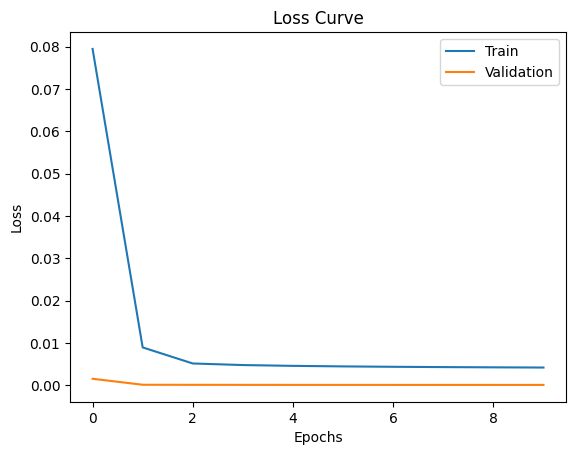

Final Test Loss: 2.4551136448280886e-05


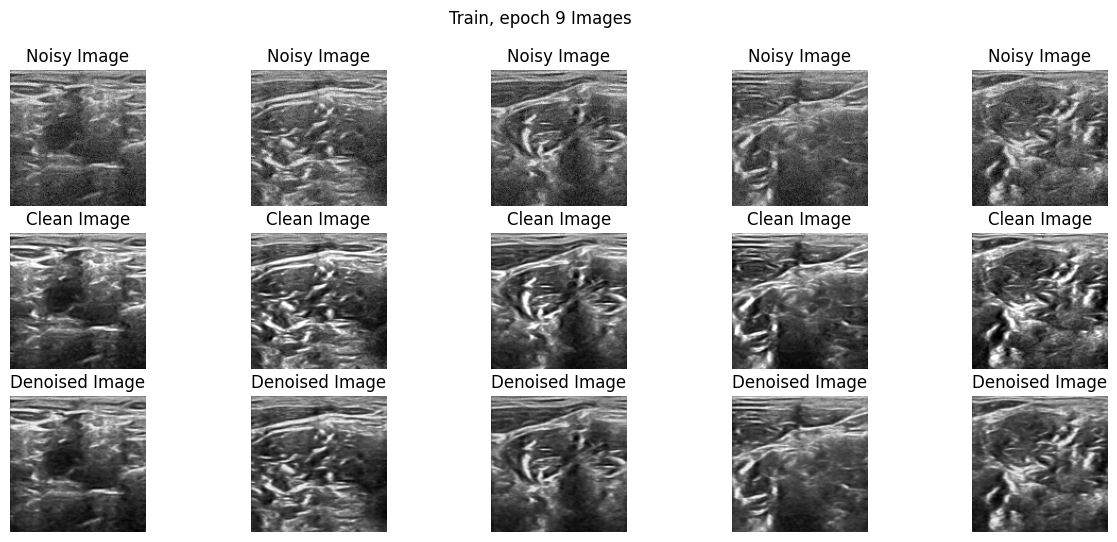

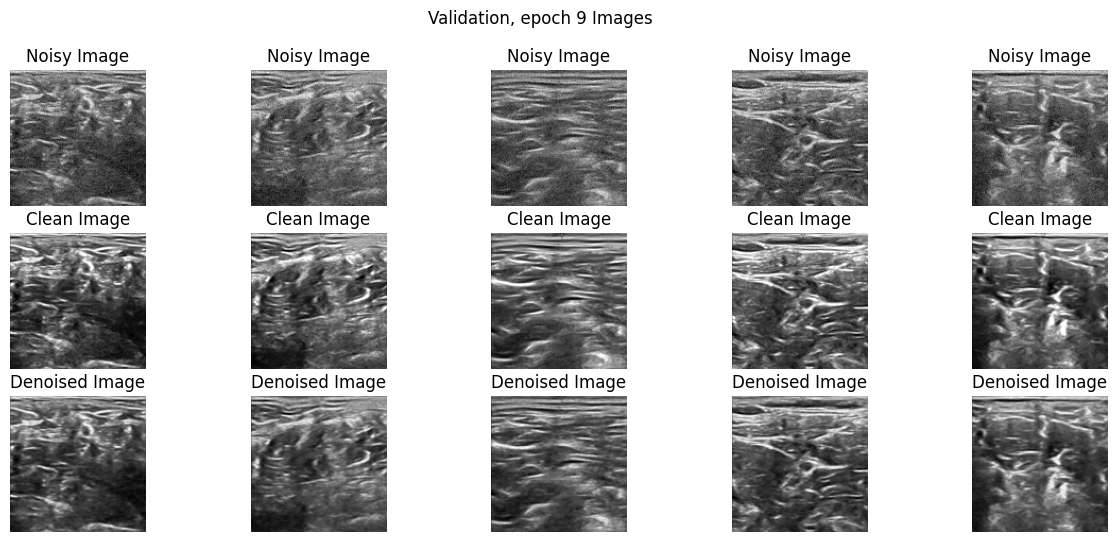

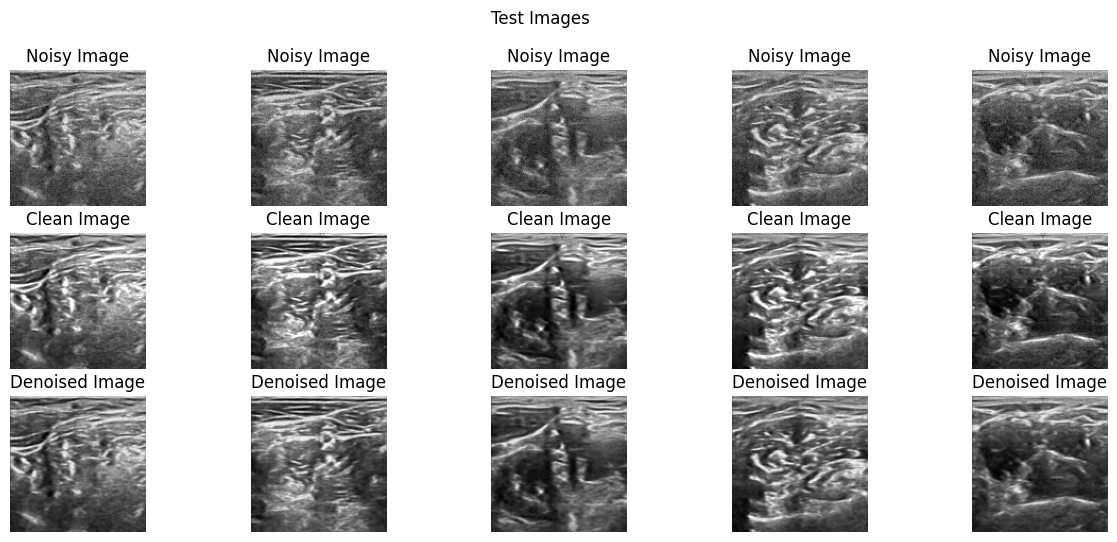

In [ ]:
# Train and test the network architecture
def launch_Br_U_Net():
    model = BatchRenormalizationUNet()

    train_dataset, val_dataset, test_dataset = train_test_split()

    train_output_list, train_loss_list, val_output_list, val_loss_list, test_output_list, test_loss_list = train_test(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        batch_size=32,
        epochs=10,
        loss_func=nn.MSELoss(),
        optimizer=optim.Adam(model.parameters(), lr=0.0001)
        )

    return model

br_u_net = launch_Br_U_Net()

# Results

In [ ]:
def ssim(noisy_img, clean_img):
    """Compute the structural similarity index (SSIM) between two images."""
    mu1 = torch.mean(noisy_img)
    mu2 = torch.mean(clean_img)
    sigma1 = torch.std(noisy_img)
    sigma2 = torch.std(clean_img)
    cov = torch.mean((noisy_img - mu1) * (clean_img - mu2))
    c1 = (0.01 * 255)**2
    c2 = (0.03 * 255)**2
    ssim = (2 * mu1 * mu2 + c1) * (2 * cov + c2) / ((mu1**2 + mu2**2 + c1) * (sigma1**2 + sigma2**2 + c2))
    return ssim

def psnr(noisy_img, clean_img):
    """Compute the peak signal-to-noise ratio (PSNR) between two images."""
    mse = torch.mean((noisy_img - clean_img)**2)
    psnr = 10 * torch.log10(1 / mse)
    return psnr

# Evaluate the PSNR and SSIM of the model on the test dataset
model_list = [di_conv_ae]  # [di_conv_ae, d_u_net, br_u_net]
_, _, test_dataset = train_test_split()
for model in model_list:
    model.eval()
    with torch.no_grad():
        for noisy_img, clean_img in test_dataset:

            noisy_img = noisy_img.unsqueeze(0)
            clean_img = clean_img.unsqueeze(0)

            outputs = model(noisy_img.to(DEVICE))
            psnr_value = psnr(outputs.to(DEVICE), clean_img.to(DEVICE))
            print(f"Model: {model}, PSNR: {psnr_value}")

            ssim_value = ssim(outputs.to(DEVICE), clean_img.to(DEVICE))
            print(f"Model: {model}, SSIM: {ssim_value}")

Loading 5500 train images...


100%|██████████| 5500/5500 [00:17<00:00, 310.55it/s]


Loading 5500 test images...


100%|██████████| 5500/5500 [00:17<00:00, 312.61it/s]


Streaming output truncated to the last 5000 lines.
    (8): LeakyReLU(negative_slope=0.1)
    (9): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (10): Tanh()
  )
), PSNR: 16.990215301513672
Model: DilatedConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (6): LeakyReLU(negative_slope=0.1)
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (8): LeakyReLU(negative_slope=0.1)
    (9): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=